# Dataloader

In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

# Define the path where CIFAR-10 is stored
data_path = "/home/teaching/miniconda3/envs/flash/data1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (Normalization helps CNN training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root=data_path, train=True, transform=transform, download=False)
test_dataset = CIFAR10(root=data_path, train=False, transform=transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True,num_workers=16)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch size: {images.shape}")  # (128, 3, 32, 32)


Batch size: torch.Size([1024, 3, 32, 32])


In [22]:


print(f"Using device: {device}")

Using device: cuda


#  Masking the feature maps

In [23]:
class MaskFeatureMap(nn.Module):
    def __init__(self, mask_ratio=0.3, patch_size=4, noise_std=0.1):
        super().__init__()
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.noise_std = noise_std
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
        num_patches_h = max(1, height // self.patch_size)
        num_patches_w = max(1, width // self.patch_size)
        num_patches = num_patches_h * num_patches_w
        num_masked = int(num_patches * self.mask_ratio)
        
        # Vectorized mask creation
        patch_mask = torch.ones(batch_size, num_patches, device=x.device)
        indices = torch.rand(batch_size, num_patches, device=x.device).argsort(dim=1)[:, :num_masked]
        patch_mask.scatter_(1, indices, 0)  # Set masked patches to 0
        patch_mask = patch_mask.view(batch_size, 1, num_patches_h, num_patches_w)
        
        # Upsample and apply
        if num_patches_h > 0 and num_patches_w > 0:
            pixel_mask = F.interpolate(patch_mask, size=(height, width), mode='nearest')
        else:
            pixel_mask = torch.ones_like(x[:, :1, :, :])
            
        pixel_mask = pixel_mask.expand(-1, channels, -1, -1)
        noise = torch.randn_like(x) * self.noise_std
        masked_x = x * pixel_mask + noise * (1 - pixel_mask)
        return masked_x

# MCAE main model

In [24]:
class MCAE(nn.Module):
    def __init__(self, mask_ratio=0.3):
        super(MCAE, self).__init__()
        
        self.mask1 = MaskFeatureMap(mask_ratio=mask_ratio, patch_size=4, noise_std=0.1)
        self.mask2 = MaskFeatureMap(mask_ratio=mask_ratio, patch_size=4, noise_std=0.1)
        
        # Encoder (4 downsampling steps: 32 → 16 → 8 → 4 → 2)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32→16
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 16→8
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.Conv2d(512, 768, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(768),
            nn.SiLU(),
            nn.Conv2d(768, 1024, kernel_size=3, stride=2, padding=1),  # 8→4
            nn.BatchNorm2d(1024),
            nn.SiLU(),
            nn.Conv2d(1024, 1536, kernel_size=3, stride=2, padding=1),  # 4→2
            nn.BatchNorm2d(1536),
            nn.SiLU()
        )
        
        # Decoder (4 upsampling steps: 2 → 4 → 8 → 16 → 32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1536, 1024, kernel_size=4, stride=2, padding=1),  # 2→4
            nn.BatchNorm2d(1024),
            nn.SiLU(),
            nn.ConvTranspose2d(1024, 768, kernel_size=4, stride=2, padding=1),  # 4→8
            nn.BatchNorm2d(768),
            nn.SiLU(),
            nn.ConvTranspose2d(768, 512, kernel_size=4, stride=2, padding=1),  # 8→16
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 16→32
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 64, kernel_size=3, padding=1),  # Refinement at 32x32
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Final output at 32x32
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder[0:4](x)
        x = self.mask1(x)
        x = self.encoder[4:10](x)
        x = self.mask2(x)
        encoded = self.encoder[10:](x)
        decoded = self.decoder(encoded)
        return decoded

# Test the model
model = MCAE(mask_ratio=0.3)
x = torch.randn(1, 3, 32, 32)  # CIFAR-10 size
output = model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 3, 32, 32])


# Our Perceptual Loss

In [25]:
class PerceptualLoss(nn.Module):
    """
    A perceptual loss implementation that is robust to dimension mismatches.
    """
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, x, y):
        """
        Calculate perceptual loss between x and y.
        Args:
            x: Predicted image
            y: Target image
        Returns:
            Combined perceptual loss
        """
        # Ensure x and y have the same dimensions
        if x.shape != y.shape:
            y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)
        
        # Use MSE as base content loss
        content_loss = self.mse(x, y)
        
        # Calculate edge loss safely - avoid dimension mismatches
        try:
            # Safer approach: Ensure the feature maps have same dimensions
            # Use min dimensions to ensure compatibility
            min_h = min(x.shape[2] - 1, y.shape[2] - 1)
            min_w = min(x.shape[3] - 1, y.shape[3] - 1)
            
            # Calculate gradients on safely cropped inputs
            x_safe = x[:, :, :min_h+1, :min_w+1]
            y_safe = y[:, :, :min_h+1, :min_w+1]
            
            # Calculate gradients for edge detection
            x_h_grad = x_safe[:, :, :, 1:] - x_safe[:, :, :, :-1]
            x_v_grad = x_safe[:, :, 1:, :] - x_safe[:, :, :-1, :]
            
            y_h_grad = y_safe[:, :, :, 1:] - y_safe[:, :, :, :-1]
            y_v_grad = y_safe[:, :, 1:, :] - y_safe[:, :, :-1, :]
            
            # Calculate edge losses separately to avoid dimension issues
            edge_h_loss = self.mse(x_h_grad, y_h_grad)
            edge_v_loss = self.mse(x_v_grad, y_v_grad)
            
            # Combine edge losses
            edge_loss = (edge_h_loss + edge_v_loss) / 2.0
            
            # Weight between content and edge loss
            total_loss = 0.5 * content_loss + 0.5 * edge_loss
            
        except Exception as e:
            # Fallback to content loss only if edge detection fails
            print(f"Warning: Edge loss calculation failed: {e}")
            total_loss = content_loss
        
        return total_loss

# Define PSNR function

In [26]:
def denormalize(img, mean, std):
    """ Convert normalized image back to [0,1] range. """
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(img.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(img.device)
    return img * std + mean

def psnr(img1, img2, data_range=1.0):
    """ Compute PSNR after denormalization. Assumes img1 and img2 are in range [0,1]. """
    img1 = denormalize(img1, mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    img2 = denormalize(img2, mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    
    mse = torch.mean((img1 - img2) ** 2)
    mse = torch.clamp(mse, min=1e-10)  # Prevent log(0)
    
    return 20 * torch.log10(data_range / torch.sqrt(mse))


# Define function for evaluating reconstruction quality

In [27]:
import torch
from skimage.metrics import structural_similarity as ssim

def denormalize(img, mean, std):
    """ Convert normalized image back to [0,1] range. """
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(img.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(img.device)
    return img * std + mean

def evaluate_reconstruction(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    total_psnr, total_ssim = 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)

            # Denormalize images before computing PSNR and SSIM
            images_dn = denormalize(images, mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
            outputs_dn = denormalize(outputs, mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])

            # Compute PSNR
            batch_psnr = psnr(images_dn, outputs_dn).item()
            total_psnr += batch_psnr

            # Convert tensors to numpy for SSIM calculation
            images_np = images_dn.cpu().numpy().transpose(0, 2, 3, 1)  # (B, H, W, C)
            outputs_np = outputs_dn.cpu().numpy().transpose(0, 2, 3, 1)

            # Compute SSIM with correct data range
            batch_ssim = ssim(images_np, outputs_np, channel_axis=-1, win_size=3, data_range=1.0).mean()
            total_ssim += batch_ssim

            num_samples += 1

    return total_psnr / num_samples, total_ssim / num_samples


# Define function for training classifier on frozen embeddings

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import GradScaler, autocast  # Updated API

import torch
import torch.nn as nn

# Define a Residual Block for fully connected layers
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual  # Skip connection
        out = self.gelu(out)
        return out

# Define the improved DeepClassifier
class DeepClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            ResidualBlock(1024),  # Residual block at 1024 units
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            ResidualBlock(512),   # Residual block at 512 units
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            ResidualBlock(256),   # Residual block at 256 units
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

def train_classifier(encoder, train_loader, test_loader, device="cuda"):
    encoder.to(device)
    encoder.eval()

    # Feature extraction
    train_features, train_labels = [], []
    test_features, test_labels = [], []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            features = encoder(images)  # Expecting (batch, feature_dim, H, W)
            features = features.mean(dim=[2, 3])  # Global Average Pooling
            train_features.append(features.cpu())
            train_labels.append(labels.cpu())

        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            features = encoder(images)
            features = features.mean(dim=[2, 3])
            test_features.append(features.cpu())
            test_labels.append(labels.cpu())

    train_features = torch.cat(train_features)
    train_labels = torch.cat(train_labels)
    test_features = torch.cat(test_features)
    test_labels = torch.cat(test_labels)

    # Normalize features (helps with training stability)
    train_features = (train_features - train_features.mean()) / (train_features.std() + 1e-8)
    test_features = (test_features - test_features.mean()) / (test_features.std() + 1e-8)

    # DataLoader for classifier
    dataset = TensorDataset(train_features, train_labels)
    train_loader_clf = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)

    # Initialize classifier
    classifier = DeepClassifier(train_features.shape[1], num_classes=10).to(device)
    optimizer = optim.AdamW(classifier.parameters(), lr=3e-4, weight_decay=1e-2)  # Adjusted LR and WD
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # Longer cycle
    scaler = GradScaler('cuda')  # Updated API

    # Training loop
    for epoch in range(100):  # More epochs for convergence
        classifier.train()
        total_loss = 0
        for feats, lbls in train_loader_clf:
            feats, lbls = feats.to(device, non_blocking=True), lbls.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with autocast('cuda'):  # Updated API
                outputs = classifier(feats)
                loss = criterion(outputs, lbls)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(train_loader_clf)
        print(f"Epoch {epoch+1}/100, Loss: {avg_loss:.4f}")

    # Evaluation
    classifier.eval()
    with torch.no_grad():
        test_features = test_features.to(device, non_blocking=True)
        test_labels = test_labels.to(device, non_blocking=True)
        with autocast('cuda'):  # Updated API
            outputs = classifier(test_features)
        accuracy = (outputs.argmax(1) == test_labels).float().mean().item() * 100  # In percentage
        print(f"Classifier Accuracy: {accuracy:.2f}%")

    return accuracy

# Example usage:
# encoder = YourEncoderModel()
# accuracy = train_deep_classifier(encoder, train_loader, test_loader)

# Function to generate heatmaps

In [29]:
import torch
import matplotlib.pyplot as plt

# CIFAR-10 Mean and Std for Unnormalization
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to("cuda")
std = torch.tensor([0.2470, 0.2435, 0.2616]).view(1, 3, 1, 1).to("cuda")

def unnormalize(tensor, mean, std):
    """Reverses normalization for visualization"""
    return tensor * std + mean

def generate_heatmaps(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= 3:
                break
            images = images.to(device)

            # Ensure images are unnormalized before heatmap calculation
            unnorm_images = unnormalize(images, mean, std)
            unnorm_images = torch.clamp(unnorm_images, 0, 1)  # Keep in valid range

            outputs = model(images)
            outputs = torch.clamp(outputs, 0, 1)  # Prevent out-of-range values
            
            # Compute absolute difference (error map)
            heatmap = torch.abs(unnorm_images - outputs).mean(dim=1).cpu()  # Mean across channels
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # Normalize
            
            # Convert to numpy for visualization
            orig_img = unnorm_images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
            heatmap_img = heatmap[0].numpy()  # (H, W)

            # Debugging print
            print(f"Input Shape: {images.shape}, Output Shape: {outputs.shape}, Heatmap Shape: {heatmap.shape}")

            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            heatmap_ax = axes[i, 1].imshow(heatmap_img, cmap="hot", vmin=0, vmax=1)
            axes[i, 1].set_title("Reconstruction Heatmap")
            axes[i, 1].axis("off")

            # Add colorbar
            cbar = fig.colorbar(heatmap_ax, ax=axes[i, 1], fraction=0.046, pad=0.04)
            cbar.set_label("Reconstruction Error", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()


# Training loop with multiple masking ratios


===== Training MCAE with Mask Ratio: 0.1 =====

Using initialization mask_ratio=0.1 for training and model saving
Training with mask_ratio=0.1


Epoch 5/100, Loss: 0.2703, Time: 13.62s, LR: 0.001000


Epoch 10/100, Loss: 0.2657, Time: 13.77s, LR: 0.001000


Epoch 15/100, Loss: 0.2649, Time: 13.73s, LR: 0.000050


Epoch 20/100, Loss: 0.2658, Time: 13.78s, LR: 0.000050


Early stopping at epoch 23 (No improvement for 10 epochs)
Final model saved as /home/teaching/miniconda3/envs/flash/models1/mcae_mask_0.1.pth
Epoch 1/100, Loss: 2.0286
Epoch 2/100, Loss: 1.9943
Epoch 3/100, Loss: 1.9862
Epoch 4/100, Loss: 1.9830
Epoch 5/100, Loss: 1.9781
Epoch 6/100, Loss: 1.9772
Epoch 7/100, Loss: 1.9735
Epoch 8/100, Loss: 1.9734
Epoch 9/100, Loss: 1.9721
Epoch 10/100, Loss: 1.9707
Epoch 11/100, Loss: 1.9641
Epoch 12/100, Loss: 1.9637
Epoch 13/100, Loss: 1.9611
Epoch 14/100, Loss: 1.9613
Epoch 15/100, Loss: 1.9613
Epoch 16/100, Loss: 1.9619
Epoch 17/100, Loss: 1.9591
Epoch 18/100, Loss: 1.9593
Epoch 19/100, Loss: 1.9598
Epoch 20/100, Loss: 1.9605
Epoch 21/100, Loss: 1.9583
Epoch 22/100, Loss: 1.9528
Epoch 23/100, Loss: 1.9510
Epoch 24/100, Loss: 1.9523
Epoch 25/100, Loss: 1.9522
Epoch 26/100, Loss: 1.9519
Epoch 27/100, Loss: 1.9511
Epoch 28/100, Loss: 1.9513
Epoch 29/100, Loss: 1.9519
Epoch 30/100, Loss: 1.9508
Epoch 31/100, Loss: 1.9503
Epoch 32/100, Loss: 1.9491
Epo

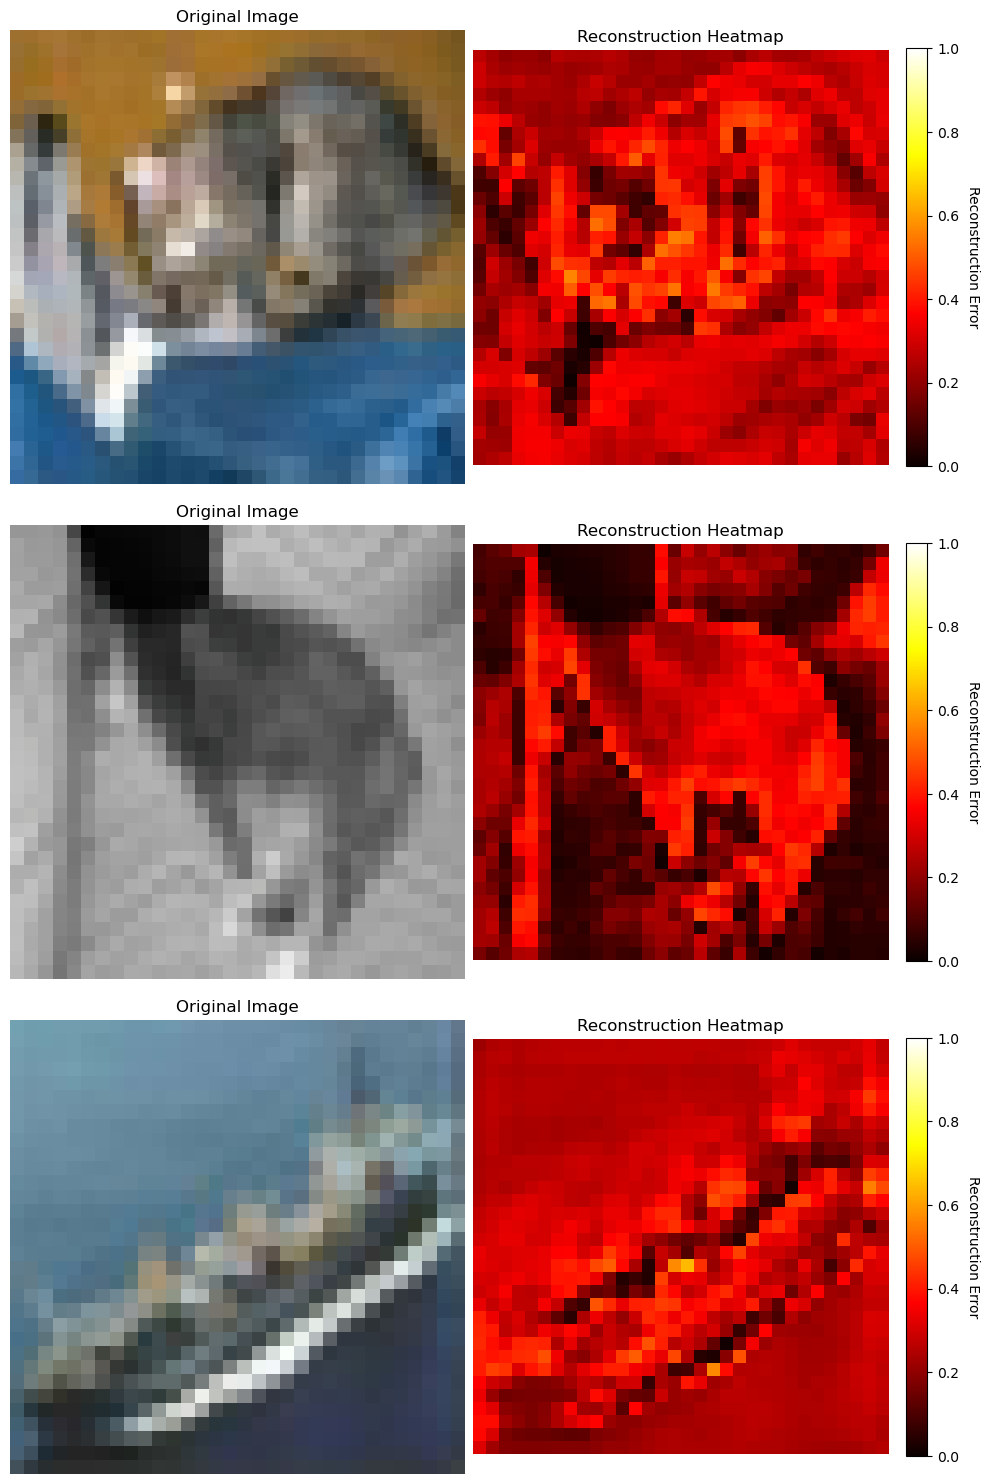


===== Training MCAE with Mask Ratio: 0.3 =====

Using initialization mask_ratio=0.3 for training and model saving
Training with mask_ratio=0.3


Epoch 5/100, Loss: 0.2847, Time: 13.76s, LR: 0.001000


Epoch 10/100, Loss: 0.2792, Time: 13.82s, LR: 0.001000


Epoch 15/100, Loss: 0.2776, Time: 13.79s, LR: 0.000050


Epoch 20/100, Loss: 0.2786, Time: 13.75s, LR: 0.000050


Early stopping at epoch 24 (No improvement for 10 epochs)
Final model saved as /home/teaching/miniconda3/envs/flash/models1/mcae_mask_0.3.pth
Epoch 1/100, Loss: 2.0315
Epoch 2/100, Loss: 1.9973
Epoch 3/100, Loss: 1.9889
Epoch 4/100, Loss: 1.9858
Epoch 5/100, Loss: 1.9823
Epoch 6/100, Loss: 1.9793
Epoch 7/100, Loss: 1.9796
Epoch 8/100, Loss: 1.9749
Epoch 9/100, Loss: 1.9765
Epoch 10/100, Loss: 1.9746
Epoch 11/100, Loss: 1.9687
Epoch 12/100, Loss: 1.9663
Epoch 13/100, Loss: 1.9649
Epoch 14/100, Loss: 1.9637
Epoch 15/100, Loss: 1.9656
Epoch 16/100, Loss: 1.9652
Epoch 17/100, Loss: 1.9637
Epoch 18/100, Loss: 1.9648
Epoch 19/100, Loss: 1.9629
Epoch 20/100, Loss: 1.9605
Epoch 21/100, Loss: 1.9606
Epoch 22/100, Loss: 1.9556
Epoch 23/100, Loss: 1.9557
Epoch 24/100, Loss: 1.9547
Epoch 25/100, Loss: 1.9548
Epoch 26/100, Loss: 1.9543
Epoch 27/100, Loss: 1.9533
Epoch 28/100, Loss: 1.9540
Epoch 29/100, Loss: 1.9535
Epoch 30/100, Loss: 1.9534
Epoch 31/100, Loss: 1.9530
Epoch 32/100, Loss: 1.9520
Epo

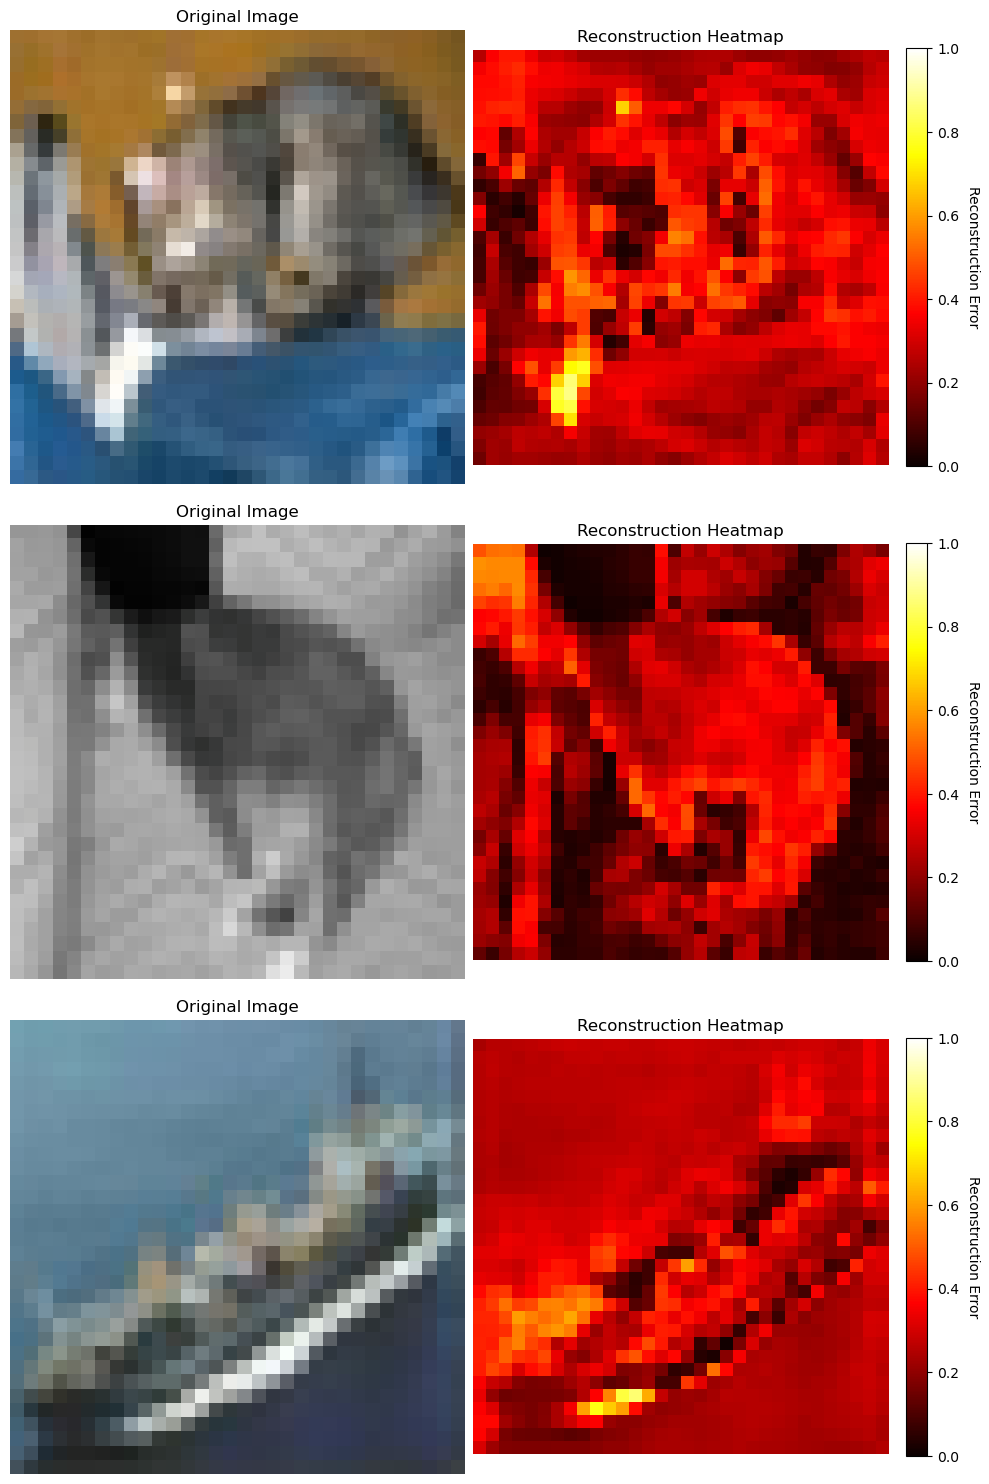


===== Training MCAE with Mask Ratio: 0.5 =====

Using initialization mask_ratio=0.5 for training and model saving
Training with mask_ratio=0.5


Epoch 5/100, Loss: 0.3175, Time: 13.75s, LR: 0.001000


Epoch 10/100, Loss: 0.3126, Time: 13.83s, LR: 0.001000


Epoch 15/100, Loss: 0.3095, Time: 13.76s, LR: 0.000050


Epoch 20/100, Loss: 0.3104, Time: 13.81s, LR: 0.000050


Early stopping at epoch 24 (No improvement for 10 epochs)
Final model saved as /home/teaching/miniconda3/envs/flash/models1/mcae_mask_0.5.pth
Epoch 1/100, Loss: 2.0441
Epoch 2/100, Loss: 2.0115
Epoch 3/100, Loss: 2.0027
Epoch 4/100, Loss: 1.9988
Epoch 5/100, Loss: 1.9946
Epoch 6/100, Loss: 1.9918
Epoch 7/100, Loss: 1.9897
Epoch 8/100, Loss: 1.9889
Epoch 9/100, Loss: 1.9885
Epoch 10/100, Loss: 1.9863
Epoch 11/100, Loss: 1.9804
Epoch 12/100, Loss: 1.9787
Epoch 13/100, Loss: 1.9771
Epoch 14/100, Loss: 1.9779
Epoch 15/100, Loss: 1.9786
Epoch 16/100, Loss: 1.9776
Epoch 17/100, Loss: 1.9771
Epoch 18/100, Loss: 1.9762
Epoch 19/100, Loss: 1.9750
Epoch 20/100, Loss: 1.9760
Epoch 21/100, Loss: 1.9733
Epoch 22/100, Loss: 1.9693
Epoch 23/100, Loss: 1.9688
Epoch 24/100, Loss: 1.9684
Epoch 25/100, Loss: 1.9678
Epoch 26/100, Loss: 1.9681
Epoch 27/100, Loss: 1.9696
Epoch 28/100, Loss: 1.9676
Epoch 29/100, Loss: 1.9673
Epoch 30/100, Loss: 1.9665
Epoch 31/100, Loss: 1.9666
Epoch 32/100, Loss: 1.9672
Epo

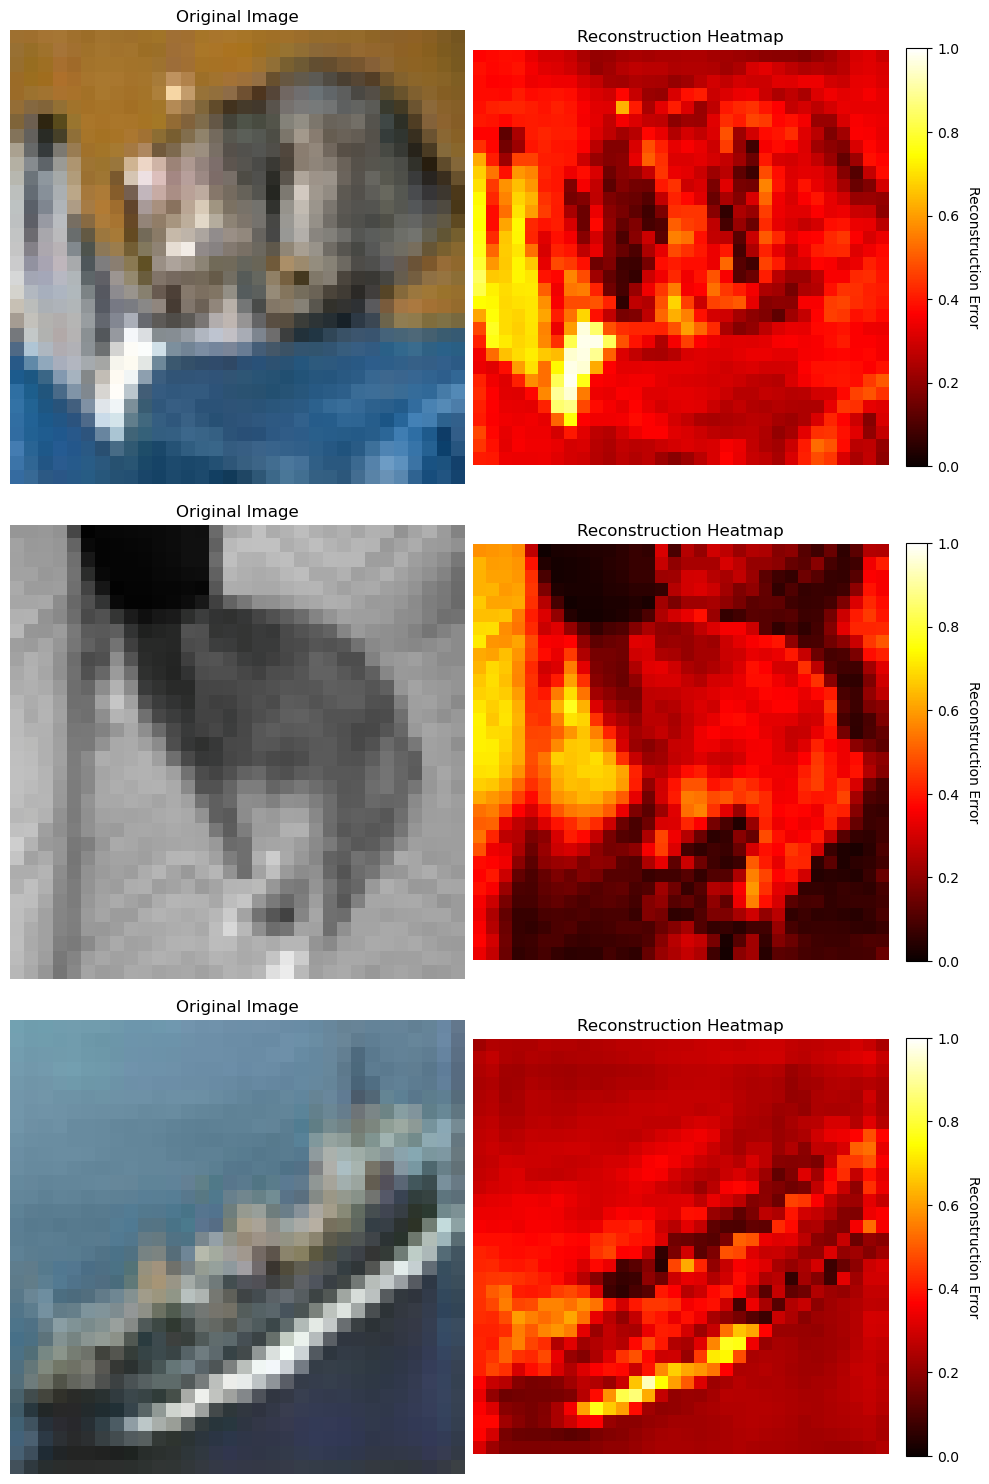


===== Summary of Results =====
Mask Ratio 0.1: Loss=0.2665, PSNR=26.71, SSIM=0.57, Acc=27.28%
Mask Ratio 0.3: Loss=0.2793, PSNR=26.50, SSIM=0.53, Acc=26.79%
Mask Ratio 0.5: Loss=0.3118, PSNR=26.00, SSIM=0.44, Acc=26.93%


In [30]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Ensure device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mcae(model, train_loader, epochs=50, mask_ratio=None, device=torch.device("cuda"), patience=5, min_delta=1e-3):
    """
    Train the MCAE model with robust error handling.
    
    Args:
        model: The MCAE model to train
        train_loader: DataLoader for training data
        epochs: Number of epochs to train
        mask_ratio: Mask ratio used for model initialization (needed for model save paths)
        device: Device to train on
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping
    
    Returns:
        Dictionary of final losses by mask ratio
    """
    # Initialize losses and optimizer
    criterion_recon = nn.SmoothL1Loss()
    criterion_perceptual = PerceptualLoss().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.05)
    scaler = torch.amp.GradScaler()
    
    # Use the mask_ratio parameter directly, since it's not stored in the model
    current_mask_ratio = mask_ratio
    
    print(f"Training with mask_ratio={current_mask_ratio}")
    
    # Training loop
    final_losses = {}
    best_loss = float('inf')
    no_improve_epochs = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        recon_loss_total = 0.0
        perceptual_loss_total = 0.0
        start_time = time.time()
        
        # Process each batch
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, _ in progress_bar:
            images = images.to(device, non_blocking=True)
            
            try:
                optimizer.zero_grad()
                
                with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                    # Forward pass
                    outputs = model(images)
                    
                    # Ensure outputs match input dimensions
                    if outputs.shape != images.shape:
                        outputs = F.interpolate(outputs, size=images.shape[2:], 
                                              mode='bilinear', align_corners=False)
                    
                    # Calculate losses
                    loss_recon = criterion_recon(outputs, images)
                    
                    # Skip perceptual loss if dimensions don't match
                    try:
                        loss_perceptual = criterion_perceptual(outputs, images)
                        perceptual_loss_total += loss_perceptual.item()
                    except Exception as e:
                        print(f"Warning: Perceptual loss calculation failed: {e}")
                        loss_perceptual = torch.tensor(0.0, device=device)
                    
                    # Weighted loss
                    alpha = min(0.5, 0.1 + (epoch / epochs) * 0.4)
                    loss = (1 - alpha) * loss_recon + alpha * loss_perceptual
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                # Track metrics
                epoch_loss += loss.item()
                recon_loss_total += loss_recon.item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': loss.item(),
                    'recon': loss_recon.item(),
                    'percep': loss_perceptual.item() if loss_perceptual.item() > 0 else 'N/A'
                })
                
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print(f"CUDA OOM error! Skipping batch and clearing cache.")
                    torch.cuda.empty_cache()
                    continue
                else:
                    print(f"Runtime error during training: {e}")
                    # Try to recover by skipping this batch
                    continue
        
        # End of epoch processing
        avg_epoch_loss = epoch_loss / len(train_loader)
        scheduler.step()
        epoch_time = time.time() - start_time
        if ( epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Time: {epoch_time:.2f}s, LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Early stopping check
        if best_loss - avg_epoch_loss > min_delta:
            best_loss = avg_epoch_loss
            no_improve_epochs = 0
            
            # Save best model
            model_path = f"/home/teaching/miniconda3/envs/flash/models1/mcae_mask_{current_mask_ratio}_best.pth"
            torch.save(model.state_dict(), model_path)
            #print(f"Best model saved as {model_path}")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
                break
    
    # Save final model
    model_path = f"/home/teaching/miniconda3/envs/flash/models1/mcae_mask_{current_mask_ratio}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Final model saved as {model_path}")
    
    final_losses[current_mask_ratio] = avg_epoch_loss
    return final_losses

# Set up mask ratios to try
mask_ratios = [0.1, 0.3, 0.5]
results = {}

for mask_ratio in mask_ratios:
    print(f"\n===== Training MCAE with Mask Ratio: {mask_ratio} =====\n")
    
    try:
        # Clear CUDA cache before each training run
        torch.cuda.empty_cache()
        
        # Create model with the current mask ratio
        model = MCAE(mask_ratio=mask_ratio).to(device)
        
        # We know the model doesn't store mask_ratio directly, so we'll track it ourselves
        print(f"Using initialization mask_ratio={mask_ratio} for training and model saving")
        
        # Train the model with robust error handling, passing the mask_ratio explicitly
        train_loss = train_mcae(
            model=model,
            train_loader=train_loader,
            epochs=100,
            mask_ratio=mask_ratio,  # Pass the mask_ratio explicitly
            device=device,
            patience=10,
            min_delta=1e-4
        )
        
        # Evaluate the model
        try:
            psnr_score, ssim_score = evaluate_reconstruction(model, test_loader)
            accuracy = train_classifier(model, train_loader, test_loader)
            
            results[mask_ratio] = {
                'train_loss': train_loss,
                'psnr': psnr_score,
                'ssim': ssim_score,
                'accuracy': accuracy
            }
            
            print(f"Mask Ratio {mask_ratio}: PSNR={psnr_score:.2f}, SSIM={ssim_score:.2f}, Classifier Acc={accuracy:.2f}")
            
            # Generate heatmaps if available
            try:
                generate_heatmaps(model, test_loader, device=device)
            except Exception as e:
                print(f"Error generating heatmaps: {e}")
        
        except Exception as e:
            print(f"Error during evaluation for mask_ratio={mask_ratio}: {e}")
    
    except Exception as e:
        print(f"Error during training for mask_ratio={mask_ratio}: {e}")
    
    # Clean up to prevent memory issues
    if 'model' in locals():
        del model
    torch.cuda.empty_cache()

# Print summary of results
print("\n===== Summary of Results =====")
for ratio, metrics in results.items():
    loss_val = list(metrics['train_loss'].values())[0] if 'train_loss' in metrics else float('nan')
    psnr = metrics.get('psnr', float('nan'))
    ssim = metrics.get('ssim', float('nan'))
    acc = metrics.get('accuracy', float('nan'))
    print(f"Mask Ratio {ratio}: Loss={loss_val:.4f}, PSNR={psnr:.2f}, SSIM={ssim:.2f}, Acc={acc:.2f}%")

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

def load_model(mask_ratio, device="cuda"):
    """Loads a trained MCAE model from a saved .pth file."""
    model = MCAE(mask_ratio=mask_ratio).to(device)  # Initialize model

    # Load checkpoint
    checkpoint = torch.load(f"/home/teaching/miniconda3/envs/flash/models1/mcae_mask_{mask_ratio}.pth", map_location=device)

    # Handle different save formats
    if "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])  # If saved as a dictionary
    else:
        model.load_state_dict(checkpoint)  # If saved directly

    model.eval()
    return model


def compare_reconstructions(mask_ratios, test_loader, device="cuda"):
    """
    Loads trained models, picks a random image from test set,
    and visualizes the real and reconstructed images for different mask ratios.
    """
    # Load models
    models = {mask_ratio: load_model(mask_ratio, device) for mask_ratio in mask_ratios}

    # Select a random image from the test set
    images, _ = next(iter(test_loader))  # Fetch a batch
    idx = random.randint(0, images.size(0) - 1)  # Select a random image
    real_image = images[idx].unsqueeze(0).to(device)  # Add batch dimension

    # Generate reconstructions
    reconstructions = {}
    with torch.no_grad():
        for mask_ratio, model in models.items():
            recon = model(real_image).cpu()  # Get output
            if recon.shape[1] == 1:  # Grayscale image case
                recon = recon.squeeze(1)
            reconstructions[mask_ratio] = recon.squeeze(0)  # Remove batch dimension

    # Plot original and reconstructed images
    fig, axes = plt.subplots(1, len(mask_ratios) + 1, figsize=(15, 5))

    # Plot original image
    orig_img = real_image.cpu().squeeze(0)
    if orig_img.shape[0] == 1:  # Grayscale
        axes[0].imshow(orig_img.squeeze(0), cmap="gray")
    else:  # RGB
        axes[0].imshow(orig_img.permute(1, 2, 0).numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot reconstructions
    for i, (mask_ratio, recon_image) in enumerate(reconstructions.items()):
        if recon_image.dim() == 2:  # Grayscale
            axes[i + 1].imshow(recon_image.numpy(), cmap="gray")
        else:  # RGB
            axes[i + 1].imshow(recon_image.permute(1, 2, 0).numpy())
        axes[i + 1].set_title(f"Mask Ratio {mask_ratio}")
        axes[i + 1].axis("off")

    plt.show()

# Example usage
mask_ratios = [0.1, 0.3, 0.5]  # Define the mask ratios you trained with
compare_reconstructions(mask_ratios, test_loader, device="cuda")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!